# Multiclass Classification

## Library and Dataset import

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np
import os
import json
import joblib
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
)
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.base import BaseEstimator, TransformerMixin

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.w2v_feature_extraction import W2VTransformer
from utils.text_preprocessing import preprocess_text, TextPreprocessor

## Not_cyberbulling pruning 

In [4]:
# not_cyberbullying pruning 
df_train = pd.read_csv("../dataset/training_set.csv")
df_train["text"] = df_train["text"].apply(preprocess_text)
df_train = df_train[ df_train["text"].notna() & df_train["text"].str.strip().astype(bool)]

df_filtered = df_train[df_train["multiclass_label"] != "not_cyberbullying"].copy()

label2id = {label: idx for idx, label in enumerate(sorted(df_filtered["multiclass_label"].unique()))}
id2label = {v: k for k, v in label2id.items()}

df_filtered["label_id"] = df_filtered["multiclass_label"].map(label2id)

X_text_pruned = df_filtered["text"]
y_multiclass = df_filtered["label_id"]

print("Final Classes:", label2id)
print("Classe Distribution:")
print(df_filtered["multiclass_label"].value_counts())

model1 = Word2Vec.load("../model/word2vec_model1.model")


Final Classes: {'age': 0, 'ethnicity': 1, 'gender': 2, 'other_cyberbullying': 3, 'religion': 4}
Classe Distribution:
multiclass_label
religion               6398
age                    6394
ethnicity              6368
gender                 6350
other_cyberbullying    6082
Name: count, dtype: int64


## GRID search

In [4]:
os.makedirs("../model/grid_search_multiclass", exist_ok=True)

# Vectorizer combinations
combinations = [
    ("BoW", CountVectorizer(max_features=350)),
    ("TF-IDF", TfidfVectorizer(max_features=350)),
    ("W2V-1", W2VTransformer(model1))
]

# Param grids per model
param_grid = {
    "LogisticRegression": {
        "model__C": [0.01, 1, 10]
    },
    "LinearSVM": {
        "model__C": [0.01, 0.1, 1, 10]
    },
    "RandomForest": {
        "model__n_estimators": [100, 200, 500, 1000],
        "model__max_depth": [None, 10, 20],
        "model__random_state": [42]
    }
}

# Classifier definitions
classifiers = [
    ("LogisticRegression", LogisticRegression(max_iter=1000), param_grid["LogisticRegression"]),
    ("RandomForest", RandomForestClassifier(), param_grid["RandomForest"]),
    ("LinearSVM", LinearSVC(max_iter=10000), param_grid["LinearSVM"])
]

# CV and scoring
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = {
    "accuracy": "accuracy",
    "precision": "precision_macro",
    "recall": "recall_macro",
    "f1": "f1_macro"
}

best_results = []

# Main grid search loop
for vec_name, vectorizer in combinations:
    for clf_name, clf, grid_params in classifiers:
        print(f"\GridSearchCV for {vec_name} + {clf_name}")

        steps = [("vectorizer", vectorizer)]
        if "W2V" in vec_name:
            steps.append(("scaler", StandardScaler()))
        steps.append(("model", clf))

        pipeline = Pipeline(steps)

        grid = GridSearchCV(
            estimator=pipeline,
            param_grid=grid_params,
            scoring=scoring,
            refit="accuracy",
            cv=cv,
            n_jobs=-1,
            verbose=1,
            return_train_score=False
        )

        grid.fit(X_text_pruned, y_multiclass)

        model_filename = f"../model/grid_search_multiclass/{clf_name}_{vec_name}_multiclass.pkl"
        joblib.dump(grid.best_estimator_, model_filename)

        best = {
            "Vectorizer": vec_name,
            "Classifier": clf_name,
            "Best Params": grid.best_params_,
            "Best Accuracy": grid.cv_results_["mean_test_accuracy"][grid.best_index_],
            "Best Precision": grid.cv_results_["mean_test_precision"][grid.best_index_],
            "Best Recall": grid.cv_results_["mean_test_recall"][grid.best_index_],
            "Best F1": grid.cv_results_["mean_test_f1"][grid.best_index_]
        }

        best_results.append(best)

# Save and print results
results_df = pd.DataFrame(best_results)
results_df = results_df.sort_values(by="Best F1", ascending=False)

print(results_df)

results_df.to_csv("../model/grid_search_multiclass/best_model_results.csv", index=False)


\GridSearchCV for BoW + LogisticRegression
Fitting 10 folds for each of 3 candidates, totalling 30 fits
\GridSearchCV for BoW + RandomForest
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


\GridSearchCV for BoW + LinearSVM
Fitting 10 folds for each of 4 candidates, totalling 40 fits
\GridSearchCV for TF-IDF + LogisticRegression
Fitting 10 folds for each of 3 candidates, totalling 30 fits
\GridSearchCV for TF-IDF + RandomForest
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


\GridSearchCV for TF-IDF + LinearSVM
Fitting 10 folds for each of 4 candidates, totalling 40 fits
\GridSearchCV for W2V-1 + LogisticRegression
Fitting 10 folds for each of 3 candidates, totalling 30 fits
\GridSearchCV for W2V-1 + RandomForest
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


\GridSearchCV for W2V-1 + LinearSVM
Fitting 10 folds for each of 4 candidates, totalling 40 fits
  Vectorizer          Classifier  \
4     TF-IDF        RandomForest   
0        BoW  LogisticRegression   
2        BoW           LinearSVM   
3     TF-IDF  LogisticRegression   
5     TF-IDF           LinearSVM   
1        BoW        RandomForest   
7      W2V-1        RandomForest   
8      W2V-1           LinearSVM   
6      W2V-1  LogisticRegression   

                                         Best Params  Best Accuracy  \
4  {'model__max_depth': None, 'model__n_estimator...       0.931818   
0                                    {'model__C': 1}       0.928463   
2                                    {'model__C': 1}       0.927640   
3                                    {'model__C': 1}       0.927608   
5                                   {'model__C': 10}       0.926912   
1  {'model__max_depth': None, 'model__n_estimator...       0.926722   
7  {'model__max_depth': None, 'model__n_estim

## K-fold Cross Validation and Model Evaluation

In [5]:
y = y_multiclass 

vectorizer_map = {
    "BoW": CountVectorizer(max_features=350),
    "TF-IDF": TfidfVectorizer(max_features=350),
    "W2V-1": W2VTransformer(model1)
}

classifier_map = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "LinearSVM": LinearSVC(max_iter=2000)
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, average="macro", zero_division=0),
    "recall": make_scorer(recall_score, average="macro", zero_division=0),
    "f1": make_scorer(f1_score, average="macro", zero_division=0)
}

results = pd.read_csv("../model/grid_search_multiclass/best_model_results.csv")
results["Best Params"] = results["Best Params"].apply(eval)

eval_results = []

for vec_name, vectorizer in vectorizer_map.items():
    for clf_name, clf in classifier_map.items():
        print(f"Validating {vec_name} + {clf_name} ...")

        row = results[(results["Vectorizer"] == vec_name) & (results["Classifier"] == clf_name)]
        if row.empty:
            print(f"No parameters found for {vec_name} + {clf_name}")
            continue
        best_params = row.iloc[0]["Best Params"]

        steps = [("vectorizer", vectorizer)]
        if "W2V" in vec_name:
            steps.append(("scaler", StandardScaler()))
        steps.append(("model", clf))

        pipeline = Pipeline(steps)
        pipeline.set_params(**best_params)

        try:
            scores = cross_validate(
                pipeline,
                X_text_pruned,
                y,
                cv=cv,
                scoring=scoring,
                n_jobs=-1
            )
        except Exception as e:
            print(f"Error evaluating {clf_name} with {vec_name}: {e}")
            scores = {}

        result = {
            "model": clf_name,
            "vectorizer": vec_name
        }

        for key in scoring.keys():
            score_values = scores.get(f"test_{key}", [np.nan])
            result[key] = np.nanmean(score_values)

        result["accuracy_std"] = np.nanstd(scores.get("test_accuracy", [np.nan]))

        eval_results.append(result)

df_eval = pd.DataFrame(eval_results)
df_eval_sorted = df_eval.sort_values(by="f1", ascending=False)

display(df_eval_sorted)
df_eval_sorted.to_csv('../model/grid_search_multiclass/multiclass_result.csv', index=False)


Validating BoW + LogisticRegression ...
Validating BoW + RandomForest ...
Validating BoW + LinearSVM ...
Validating TF-IDF + LogisticRegression ...
Validating TF-IDF + RandomForest ...
Validating TF-IDF + LinearSVM ...
Validating W2V-1 + LogisticRegression ...
Validating W2V-1 + RandomForest ...
Validating W2V-1 + LinearSVM ...


,model,vectorizer,accuracy,precision,recall,f1,accuracy_std
4,RandomForest,TF-IDF,0.931818,0.933303,0.931313,0.931733,0.004533
0,LogisticRegression,BoW,0.928463,0.931737,0.928180,0.928653,0.005186
2,LinearSVM,BoW,0.927640,0.931363,0.927390,0.927826,0.005220
3,LogisticRegression,TF-IDF,0.927608,0.930571,0.927274,0.927727,0.005960
5,LinearSVM,TF-IDF,0.926912,0.929605,0.926560,0.926956,0.005216
1,RandomForest,BoW,0.926722,0.927857,0.926100,0.926560,0.005633
7,RandomForest,W2V-1,0.891776,0.897811,0.891407,0.891766,0.006047
8,LinearSVM,W2V-1,0.878450,0.877053,0.877139,0.876625,0.004443
6,LogisticRegression,W2V-1,0.877785,0.877308,0.876570,0.876603,0.004445



--- RandomForest + TF-IDF ---
Accuracy:             0.9306
Balanced Accuracy:    0.9305
Macro Precision:      0.9339
Macro Recall:         0.9305
Macro F1 Score:       0.9313


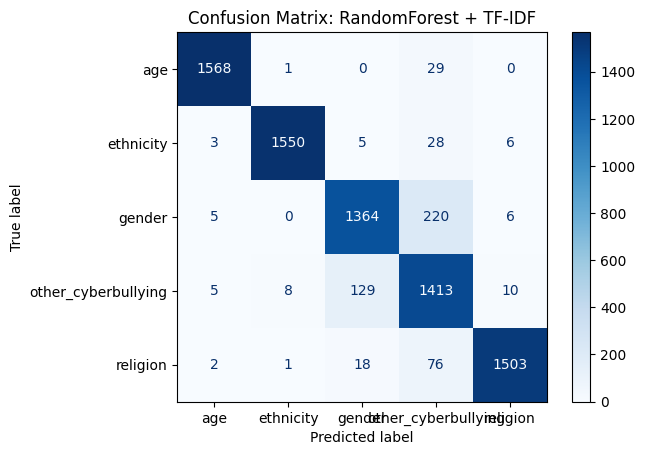


--- LogisticRegression + BoW ---
Accuracy:             0.9274
Balanced Accuracy:    0.9274
Macro Precision:      0.9319
Macro Recall:         0.9274
Macro F1 Score:       0.9283


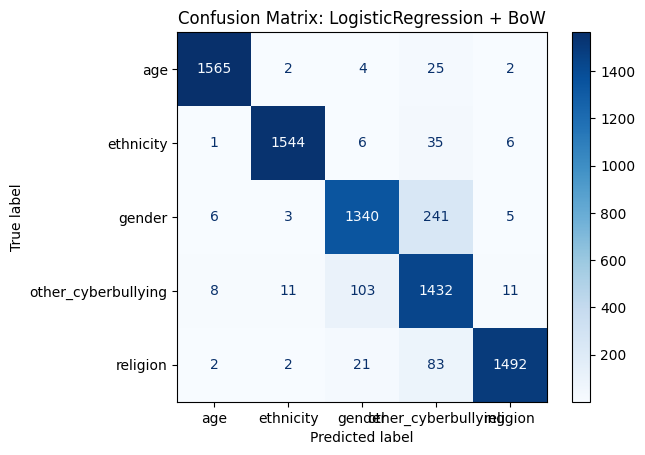


--- LinearSVM + BoW ---
Accuracy:             0.9281
Balanced Accuracy:    0.9280
Macro Precision:      0.9333
Macro Recall:         0.9280
Macro F1 Score:       0.9289


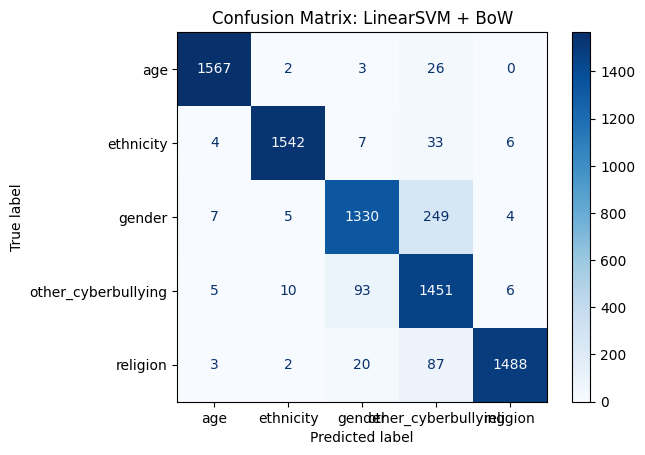


--- LogisticRegression + TF-IDF ---
Accuracy:             0.9257
Balanced Accuracy:    0.9256
Macro Precision:      0.9298
Macro Recall:         0.9256
Macro F1 Score:       0.9265


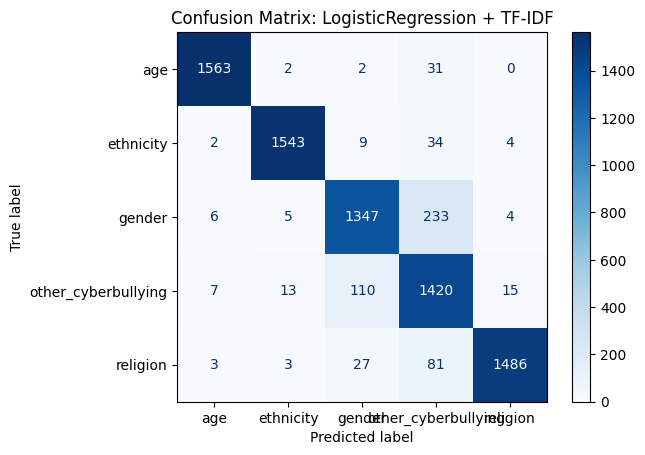


--- LinearSVM + TF-IDF ---
Accuracy:             0.9273
Balanced Accuracy:    0.9272
Macro Precision:      0.9310
Macro Recall:         0.9272
Macro F1 Score:       0.9281


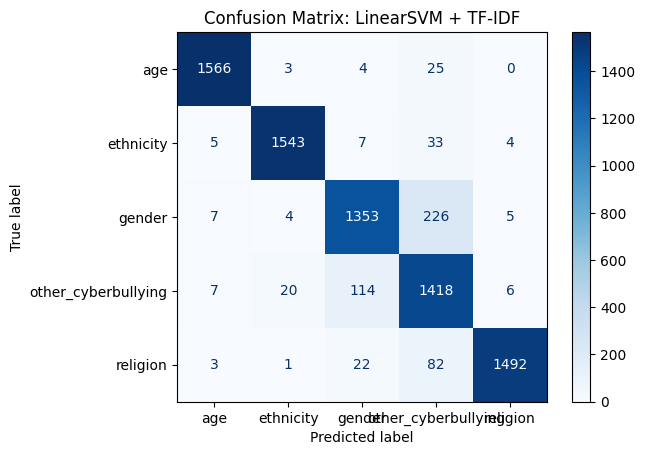


--- RandomForest + BoW ---
Accuracy:             0.9247
Balanced Accuracy:    0.9245
Macro Precision:      0.9275
Macro Recall:         0.9245
Macro F1 Score:       0.9254


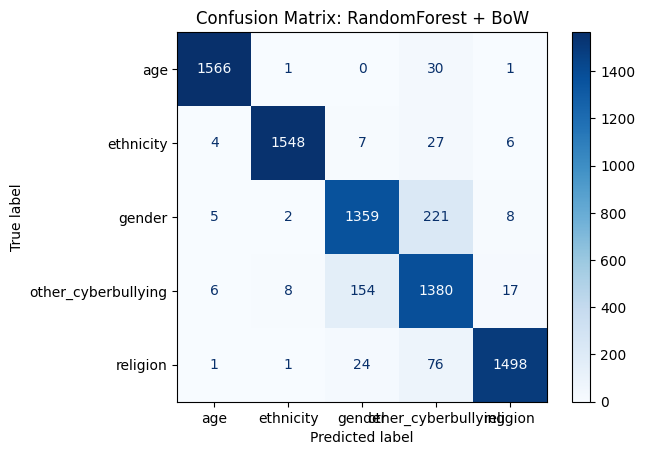


--- McNemar Test between Top 2 Models ---
McNemar's test statistic = 123.0, p-value = 0.1447
The difference is not statistically significant.


In [5]:
df_eval_sorted = pd.read_csv('../model/grid_search_multiclass/multiclass_result.csv')
df_test = pd.read_csv("../dataset/test_set.csv")
df_test = df_test[df_test["multiclass_label"] != "not_cyberbullying"]
X_test_text = df_test["text"]
y_test = df_test["multiclass_label"].map(label2id)

labels = list(label2id.keys())

def print_metrics_and_confmat_multiclass(y_true, y_pred, labels, title):
    print(f"\n--- {title} ---")
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    bal_acc = balanced_accuracy_score(y_true, y_pred)

    print(f"Accuracy:             {acc:.4f}")
    print(f"Balanced Accuracy:    {bal_acc:.4f}")
    print(f"Macro Precision:      {prec:.4f}")
    print(f"Macro Recall:         {rec:.4f}")
    print(f"Macro F1 Score:       {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: {title}")
    plt.show()

top_models = df_eval_sorted.head(6)
predictions = []

for _, row in top_models.iterrows():
    model_name = row["model"]
    vectorizer_name = row["vectorizer"]
    
    file_path = f"../model/grid_search_multiclass/{model_name}_{vectorizer_name}_multiclass.pkl"
    clf = joblib.load(file_path)

    full_pipeline = Pipeline([
        ("preprocessing", TextPreprocessor()),
        *clf.steps
    ])
    
    y_pred = full_pipeline.predict(X_test_text)
    predictions.append(y_pred)

    print_metrics_and_confmat_multiclass(y_test, y_pred, labels, f"{model_name} + {vectorizer_name}")

print("\n--- McNemar Test between Top 2 Models ---")
y_pred_1 = predictions[0]
y_pred_2 = predictions[1]


b = np.sum((y_pred_1 == y_test.values) & (y_pred_2 != y_test.values))
c = np.sum((y_pred_1 != y_test.values) & (y_pred_2 == y_test.values))

table = [[0, b], [c, 0]]
result = mcnemar(table, exact=True)

print(f"McNemar's test statistic = {result.statistic}, p-value = {result.pvalue:.4f}")
if result.pvalue < 0.05:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")
